# Πρόβλεψη COVID­-19 Κρουσμάτων με το Apache Spark
## Εξόρυξη Δεδομένων Μεγάλου Όγκου, Έτος 2020

Χουλιαράς Ανδρέας

## Εκκίνηση SparkSession

## Εισαγωγή Δεδομένων Χωρών

Τα δεδομένα αυτά περιέχουν τις τιμές από όλες τις χώρες.

Διαβάζουμε τα αρχεία CSV σε dataframes

In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-4219b7e6-8bb1-499c-b8de-26f2c3f19699',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': '-xqgzVypU8NQCEb0Odg6aTshnbtkBqvaSmqffLS5wsk8'
}

configuration_name = 'os_42ab0f413afd4dafbd1616d8723b81bc_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('countries-aggregated.csv', 'default-donotdelete-pr-jkm5xb0qblogua'))
data.take(5)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20201208013909-0002
KERNEL_ID = b187713b-89b0-422e-97fb-7eeb5e1a1ef7


[Row(Date='2020-01-22', Country='Afghanistan', Confirmed='0', Recovered='0', Deaths='0'),
 Row(Date='2020-01-23', Country='Afghanistan', Confirmed='0', Recovered='0', Deaths='0'),
 Row(Date='2020-01-24', Country='Afghanistan', Confirmed='0', Recovered='0', Deaths='0'),
 Row(Date='2020-01-25', Country='Afghanistan', Confirmed='0', Recovered='0', Deaths='0'),
 Row(Date='2020-01-26', Country='Afghanistan', Confirmed='0', Recovered='0', Deaths='0')]

## Εισαγωγή Χρήσιμων Βιβλιοθηκών

In [2]:
#!pip install fastai --upgrade

In [3]:
#Pyspark/SQL libs
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, lag, udf, unix_timestamp, to_date, rand
from pyspark.sql.types import DateType, IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor

#Data Processing Libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from fastai.tabular import *
from fastai.tabular.core import add_datepart
import six
import re

/home/spark/shared/user-libs/python/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Κατανοώντας τα Δεδομένα μας

Τα δεδομένα countries-aggregated.csv έχουν τις εξής στήλες:

*   Date: Ημερομηνία καταχώρησης. Από 22 Ιανουαρίου εώς 7 Νοεμβρίου του 2020.
*   Country: Η χώρα στην οποία αναφερόμαστε
*   Confirmed: Συνολικά επιβεβαιωμένα κρούσματα μέχρι την εκάστοτε ημερομηνία
*   Recovered: Συνολικές αναρρώσεις μέχρι την εκάστοτε ημερομηνία
*   Deaths: Συνολικοί θανάτοι μέχρι την εκάστοτε ημερομηνία

In [4]:
data.columns

['Date', 'Country', 'Confirmed', 'Recovered', 'Deaths']

### Αλλάζοντας τους τύπους των μεταβλητών

Βλέπουμε παρακάτω τους τύπους δεδομένων αν είναι εντάξει και παρατηρούμε πως οι ημερομηνίες είναι σε μορφή String. Οπότε με κατάλληλες ενέργειες μετατρέπουμε την παράμετρο στον τυπο ημερομηνίας date που υποστηρίζει το PySpark.

In [5]:
data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Confirmed: string (nullable = true)
 |-- Recovered: string (nullable = true)
 |-- Deaths: string (nullable = true)



In [6]:
data=data.withColumn('Date', to_date(unix_timestamp(col('Date'),'yyyy-MM-dd').cast("timestamp")))

In [7]:
data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- Confirmed: string (nullable = true)
 |-- Recovered: string (nullable = true)
 |-- Deaths: string (nullable = true)



Εφαρμόζουμε κατάλληλους μετασχηματισμούς στον τυπο δεδομένων ημερομηνίας ώστε να αξιοποιήσουμε καλύτερα τις πληροφορίες που περιέχει.

In [8]:
data = add_datepart(data.toPandas(), "Date", drop=False)
data = spark.createDataFrame(data).drop('Is_year_end').drop('Is_year_start')
data = data.fillna(0)
data.cache()
data = data.withColumn("Confirmed",col("Confirmed").cast('int'))
data = data.withColumn("Recovered",col("Recovered").cast('int'))
data = data.withColumn("Deaths",col("Deaths").cast('int'))
data = data.withColumn("Is_month_end",col("Is_month_end").cast('string'))
data = data.withColumn("Is_month_start",col("Is_month_start").cast('string'))
data = data.withColumn("Is_quarter_end",col("Is_quarter_end").cast('string'))
data = data.withColumn("Is_quarter_start",col("Is_quarter_start").cast('string'))
data.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Week: long (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Day: long (nullable = true)
 |-- Dayofweek: long (nullable = true)
 |-- Dayofyear: long (nullable = true)
 |-- Is_month_end: string (nullable = true)
 |-- Is_month_start: string (nullable = true)
 |-- Is_quarter_end: string (nullable = true)
 |-- Is_quarter_start: string (nullable = true)
 |-- Elapsed: long (nullable = true)



Τώρα κάθε μεταβλητή έχει τον σωστό τύπο δεδομένων.

Ας δούμε μια προεπισκόπηση των 10 πρώτων καταχωρήσεων στα δεδομένα

In [9]:
data.show(10)

+-------------------+-----------+---------+----+---------+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+
|               Date|    Country|Confirmed|Week|Recovered|Deaths|Year|Month|Day|Dayofweek|Dayofyear|Is_month_end|Is_month_start|Is_quarter_end|Is_quarter_start|   Elapsed|
+-------------------+-----------+---------+----+---------+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+
|2020-01-22 00:00:00|Afghanistan|        0|   4|        0|     0|2020|    1| 22|        2|       22|       false|         false|         false|           false|1579651200|
|2020-01-23 00:00:00|Afghanistan|        0|   4|        0|     0|2020|    1| 23|        3|       23|       false|         false|         false|           false|1579737600|
|2020-01-24 00:00:00|Afghanistan|        0|   4|        0|     0|2020|    1| 24|        4|       24|       false|         false|         fal

Όλα φαίνονται καλά.

### Εξαγωγή δεδομένων Ελλάδας

Απομονώνουμε τα δεδομένα που αφορούν μόνο την Ελλάδα
και υπολογίζουμε πόσες καταχωρήσεις έχουμε:

In [10]:
greece_data = data.filter(data.Country == 'Greece').drop('Country')
greece_data.show(10)

+-------------------+---------+----+---------+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+
|               Date|Confirmed|Week|Recovered|Deaths|Year|Month|Day|Dayofweek|Dayofyear|Is_month_end|Is_month_start|Is_quarter_end|Is_quarter_start|   Elapsed|
+-------------------+---------+----+---------+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+
|2020-01-22 00:00:00|        0|   4|        0|     0|2020|    1| 22|        2|       22|       false|         false|         false|           false|1579651200|
|2020-01-23 00:00:00|        0|   4|        0|     0|2020|    1| 23|        3|       23|       false|         false|         false|           false|1579737600|
|2020-01-24 00:00:00|        0|   4|        0|     0|2020|    1| 24|        4|       24|       false|         false|         false|           false|1579824000|
|2020-01-25 00:00:00|        0|   4|    

Τα δεδομένα μας εκτείνονται σε 291 μέρες.

In [11]:
greece_data.count(), len(greece_data.columns)

(291, 15)

### Προβολή Δεδομένων

Εμφανίζουμε διαγραμματικά τα δεδομένα μας.

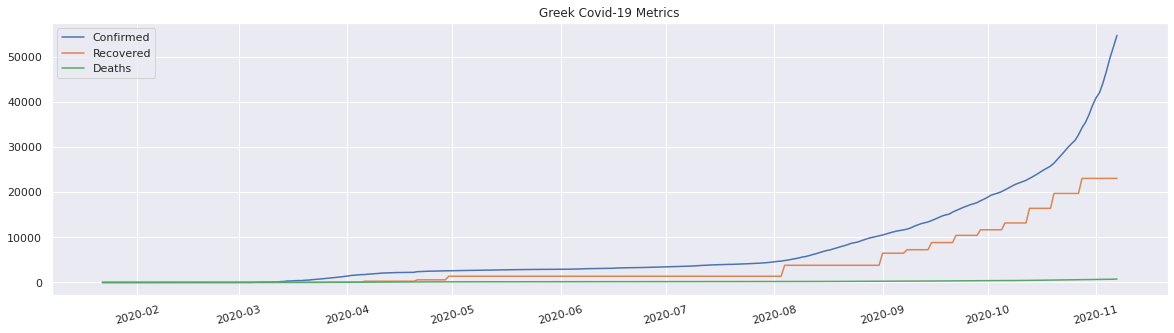

In [12]:
df=greece_data.toPandas()

sns.set()

plt.figure(figsize=(20,5))
plt.plot('Date', 'Confirmed', data=df, label="Confirmed")
plt.plot('Date', 'Recovered', data=df, label="Recovered")
plt.plot('Date', 'Deaths', data=df, label="Deaths")
plt.xticks(rotation=15)
plt.title('Greek Covid-19 Metrics')
plt.legend()
plt.show()

**Θα επικεντρωθούμε στα νούμερα των συνολικών θανάτων**

In [13]:
greece_data = greece_data.drop('Confirmed').drop('Recovered')
greece_data.show(10)

+-------------------+----+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+
|               Date|Week|Deaths|Year|Month|Day|Dayofweek|Dayofyear|Is_month_end|Is_month_start|Is_quarter_end|Is_quarter_start|   Elapsed|
+-------------------+----+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+
|2020-01-22 00:00:00|   4|     0|2020|    1| 22|        2|       22|       false|         false|         false|           false|1579651200|
|2020-01-23 00:00:00|   4|     0|2020|    1| 23|        3|       23|       false|         false|         false|           false|1579737600|
|2020-01-24 00:00:00|   4|     0|2020|    1| 24|        4|       24|       false|         false|         false|           false|1579824000|
|2020-01-25 00:00:00|   4|     0|2020|    1| 25|        5|       25|       false|         false|         false|           false|1579910400|
|2020-01-26 00:00:00

In [14]:
from pyspark.sql.window import Window

w = Window().partitionBy().orderBy(col("Deaths"))

if not "Last_Day" in greece_data.columns:
  greece_data = greece_data.select("*", lag("Deaths", offset= 7).over(w).alias("Last_Day")).na.drop()

In [15]:
greece_data.count(), len(greece_data.columns)

(284, 14)

In [16]:
greece_data.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Week: long (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Day: long (nullable = true)
 |-- Dayofweek: long (nullable = true)
 |-- Dayofyear: long (nullable = true)
 |-- Is_month_end: string (nullable = true)
 |-- Is_month_start: string (nullable = true)
 |-- Is_quarter_end: string (nullable = true)
 |-- Is_quarter_start: string (nullable = true)
 |-- Elapsed: long (nullable = true)
 |-- Last_Day: integer (nullable = true)



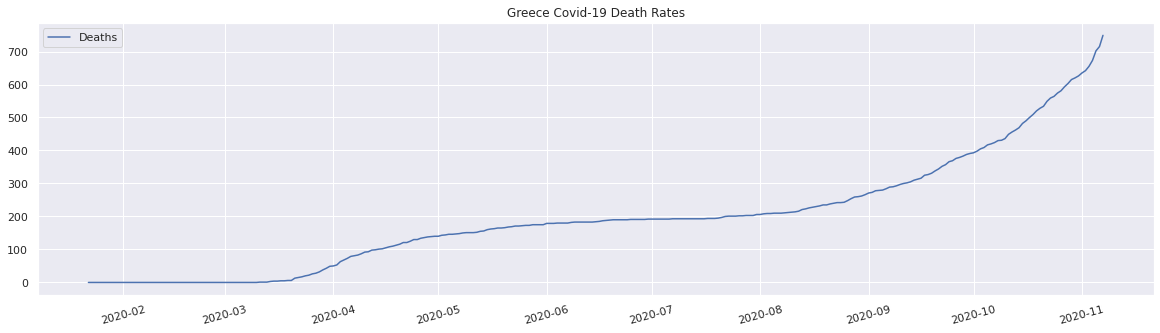

In [17]:
plt.figure(figsize=(20,5))
plt.plot('Date', 'Deaths', data=df, label="Deaths")
plt.xticks(rotation=15)
plt.title('Greece Covid-19 Death Rates')
plt.legend()
plt.show()

### Κατηγοριοποίηση Χαρακτηριστικών

Ξεχωρίζουμε τα ονόματα των μεταβλητών με βάση τον τύπο των δεδομένων τους για πιο αυτοματοποιημένη επεξεργασία

In [18]:
#Dependent Var
dep_var = 'Deaths'

#For quick access 
all_columns = greece_data.columns

#Categorical
categ_columns = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']

#Continuous 
cont_columns = ['Last_Day','Elapsed']

tf_columns=['Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start']

## Ορισμός Spark Data Pipeline

Με τα pipelines του Pyspark, τα δεδομένα που παρέχουμε θα μετασχηματιστούν και θα διανυσματοποιηθούν ανά χαρακτηριστικό ώστε να είναι έτοιμα για το μοντέλο μας.

Ορίζουμε τις διαδικασίες που θέλουμε να πραγματοποιηθούν και τις ενθέτουμε στο Pipeline.

In [19]:
# Pipeline Stages List
stages = []

### Αναδιάταξη True/False σε Δυαδική μορφή 0/1

In [20]:
# Loop for StringIndexer and OHE for Categorical Variables
for col_name in tf_columns:
    
    # Index Categorical Features
    string_indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")

    # Append Pipeline Stages
    stages += [string_indexer]

tf_columns = [s + "_index" for s in tf_columns]

### Όρισμος Μετασχηματιστή Χαρακτηριστικών

Επιλέγουμε τα χαρακτηριστικά τα οποία θα διανυσματοποιήσουμε για να χρησιμοποιηθούν στην διαδικασία της εκπαίδευσης



In [21]:
selected_features = categ_columns + cont_columns
#+ tf_columns
vectorAssembler = VectorAssembler(
    inputCols = selected_features,
    outputCol = 'features')

# Append Pipeline Stages
stages += [vectorAssembler]

Με την εντολή `stages` μπορούμε να δούμε ποιά είναι η σειρά με την οποία θα εκτελεστούν οι διαδικασίες μας στο PySpark Pipeline.



In [22]:
stages

[StringIndexer_19063d85712e,
 StringIndexer_64b621992b82,
 StringIndexer_a23429d79649,
 StringIndexer_3497a06b0ada,
 VectorAssembler_403d3a33d909]

### Δημιουργία Pipeline και μετασχηματισμός δεδομένων

Μετά δημιουργούμε το Pipeline και μετασχηματίζουμε τα δεδομένα μας.

Τα δεδομένα μοιράζονται κατάλληλα ανά διαδικασία και επεξεργάζονται από τις επιμέρους διαδικασίες. 

Ο Μετασχηματιστής που βρίσκεται στο τελευταίο βήμα χρειάζεται όλα τα προηγούμενα δεδομένα. Όπως μπορούμε να παρατηρήσουμε δεν χρειάστηκε πουθενά να ασχοληθούμε με: 
* Παράλληλους επεξεργαστές
* Θέματα συγχρονισμού
* Κατακερματισμό εργασιών σε αυτούς, κλπ

Το όφελος του Spark Framework είναι ότι όλα αυτά γίνονται αυτόματα χωρίς την επέμβαση του προγραμματιστή.

In [23]:
# Set Pipeline
pipeline = Pipeline(stages=stages)

# Fit Pipeline to Data
pipeline_model = pipeline.fit(greece_data)

# Transform Data using Fitted Pipeline
df_transform = pipeline_model.transform(greece_data)

In [24]:
# Preview Newly Transformed Data
df_transform.show()

+-------------------+----+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+--------+------------------+--------------------+--------------------+----------------------+--------------------+
|               Date|Week|Deaths|Year|Month|Day|Dayofweek|Dayofyear|Is_month_end|Is_month_start|Is_quarter_end|Is_quarter_start|   Elapsed|Last_Day|Is_month_end_index|Is_month_start_index|Is_quarter_end_index|Is_quarter_start_index|            features|
+-------------------+----+------+----+-----+---+---------+---------+------------+--------------+--------------+----------------+----------+--------+------------------+--------------------+--------------------+----------------------+--------------------+
|2020-01-29 00:00:00|   5|     0|2020|    1| 29|        2|       29|       false|         false|         false|           false|1580256000|       0|               0.0|                 0.0|                 0.0|                   0.0|[2020.

## Προετοιμασία δεδομένων

### Απομόνωση των δεδομένων που θα χρειαστούν στην εκπαίδευση

In [25]:
v_greece_data = df_transform.select(['features', dep_var])
v_greece_data.tail(20)

[Row(features=DenseVector([2020.0, 10.0, 43.0, 19.0, 0.0, 293.0, 456.0, 1603065600.0]), Deaths=520),
 Row(features=DenseVector([2020.0, 10.0, 43.0, 20.0, 1.0, 294.0, 462.0, 1603152000.0]), Deaths=528),
 Row(features=DenseVector([2020.0, 10.0, 43.0, 21.0, 2.0, 295.0, 469.0, 1603238400.0]), Deaths=534),
 Row(features=DenseVector([2020.0, 10.0, 43.0, 22.0, 3.0, 296.0, 482.0, 1603324800.0]), Deaths=549),
 Row(features=DenseVector([2020.0, 10.0, 43.0, 23.0, 4.0, 297.0, 490.0, 1603411200.0]), Deaths=559),
 Row(features=DenseVector([2020.0, 10.0, 43.0, 24.0, 5.0, 298.0, 500.0, 1603497600.0]), Deaths=564),
 Row(features=DenseVector([2020.0, 10.0, 43.0, 25.0, 6.0, 299.0, 509.0, 1603584000.0]), Deaths=574),
 Row(features=DenseVector([2020.0, 10.0, 44.0, 26.0, 0.0, 300.0, 520.0, 1603670400.0]), Deaths=581),
 Row(features=DenseVector([2020.0, 10.0, 44.0, 27.0, 1.0, 301.0, 528.0, 1603756800.0]), Deaths=593),
 Row(features=DenseVector([2020.0, 10.0, 44.0, 28.0, 2.0, 302.0, 534.0, 1603843200.0]), Dea

In [26]:
# Data Structure Type is a PySpark Dataframe
type(v_greece_data)

pyspark.sql.dataframe.DataFrame

### Διαμερισματοποίηση Δεδομένων για Εκπαίδευση και Τεστάρισμα

In [27]:
def data_builder(spark_df, part_index):
  train_df = spark.createDataFrame(spark_df.toPandas()[:part_index])
  valid_df = spark.createDataFrame(spark_df.toPandas()[part_index:])
  return train_df, valid_df

In [28]:
v_greece_data.index = greece_data.toPandas().index
valid_index =  int(v_greece_data.toPandas().shape[0] * .95)

greek_train_df, greek_test_df = data_builder(v_greece_data, valid_index)

print(greek_train_df.toPandas().shape, greek_test_df.toPandas().shape)

(269, 2) (15, 2)


In [29]:
greek_test_df.show(10)

+--------------------+------+
|            features|Deaths|
+--------------------+------+
|[2020.0,10.0,43.0...|   564|
|[2020.0,10.0,43.0...|   574|
|[2020.0,10.0,44.0...|   581|
|[2020.0,10.0,44.0...|   593|
|[2020.0,10.0,44.0...|   603|
|[2020.0,10.0,44.0...|   615|
|[2020.0,10.0,44.0...|   620|
|[2020.0,10.0,44.0...|   626|
|[2020.0,11.0,44.0...|   635|
|[2020.0,11.0,45.0...|   642|
+--------------------+------+
only showing top 10 rows



## Εκπαίδευση μοντέλου

Linear Regression
Gradient-boosted Tree Regression

In [30]:
lr = LinearRegression(featuresCol="features", labelCol=dep_var, maxIter=20, regParam=0, elasticNetParam=1)
lr_model = lr.fit(greek_train_df)

In [31]:
print("Coefficients for All Features: " + str(lr_model.coefficients))
print("Intercept for All Features: " + str(lr_model.intercept))
print("")

Coefficients for All Features: [0.0,-79.7962763961471,5.813763518986872,-2.4807775813037223,0.8201210787956221,0.8318927821506096,1.1520847798850626,9.62838735398246e-06]
Intercept for All Features: -15109.941847529444



## Προβλέποντας πάνω σε νέα Δεδομένα

In [32]:
greek_preds_reg = lr_model.transform(greek_test_df) 

greek_preds_reg.show(15)

+--------------------+------+-----------------+
|            features|Deaths|       prediction|
+--------------------+------+-----------------+
|[2020.0,10.0,43.0...|   564|549.6916162728467|
|[2020.0,10.0,43.0...|   574| 560.063508238838|
|[2020.0,10.0,44.0...|   581|572.8124857320199|
|[2020.0,10.0,44.0...|   593|582.0322929181275|
|[2020.0,10.0,44.0...|   603|588.9479305444638|
|[2020.0,10.0,44.0...|   615|606.2323311897653|
|[2020.0,10.0,44.0...|   620|617.7563079356423|
|[2020.0,10.0,44.0...|   626|623.5198607820967|
|[2020.0,11.0,44.0...|   635|632.1516661522401|
|[2020.0,11.0,45.0...|   642|640.2923045258794|
|[2020.0,11.0,45.0...|   655|654.1204508315277|
|[2020.0,11.0,45.0...|   673|665.6444275774047|
|[2020.0,11.0,45.0...|   702|679.4725738830512|
|[2020.0,11.0,45.0...|   715|685.2361267295037|
|[2020.0,11.0,45.0...|   749|  692.15176435584|
+--------------------+------+-----------------+



In [33]:
#Training Summaries for the 3 Models 
trainingSummary_reg = lr_model.summary

#Performance Metrics for model with all-features
print("RMSE w/ All Features: %f" % trainingSummary_reg.rootMeanSquaredError)
print("r2(All Features): %f" % trainingSummary_reg.r2)
print('')

RMSE w/ All Features: 10.973109
r2(All Features): 0.993265



## Απεικόνηση Προβλέψεων

In [34]:
#Convert to Pandas Dataframe
pred_reg_df = pd.DataFrame(greece_data.toPandas())

#Set Date as index
pred_reg_df['Date'] = pd.to_datetime(pred_reg_df['Date'])
pred_reg_df = pred_reg_df.set_index('Date')

#Get Trained Graph
pred_reg_train_df = pred_reg_df[:valid_index]

#Get Test Graph + Predictions
pred_reg_test_df = pred_reg_df[valid_index:]
pred_reg_test_df = pred_reg_test_df.assign(Predictions = greek_preds_reg.toPandas()['prediction'].tolist())

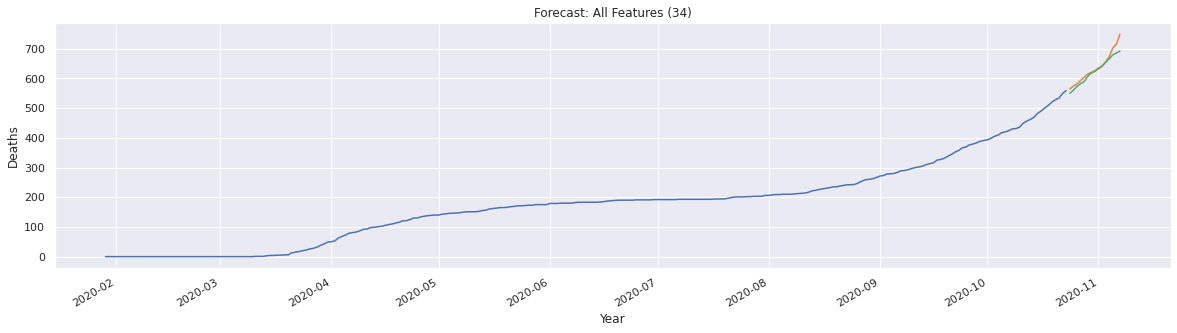

In [35]:
fig, ax = plt.subplots(1, figsize=(20, 5))

ax.set_title('Forecast: All Features (34)')
ax.set_ylabel(dep_var)
ax.set_xlabel('Year')
fig.autofmt_xdate()
ax.plot(pred_reg_train_df[dep_var])
ax.plot(pred_reg_test_df[[dep_var, 'Predictions']])

### Εστίαση γραφίματος

In [36]:
#Drop First Days for Better View
pred_reg_train_df = pred_reg_train_df.iloc[180:]

#Get Test Graph + Predictions
pred_reg_test_df = pred_reg_df[valid_index:]
pred_reg_test_df = pred_reg_test_df.assign(Predictions = greek_preds_reg.toPandas()['prediction'].tolist())

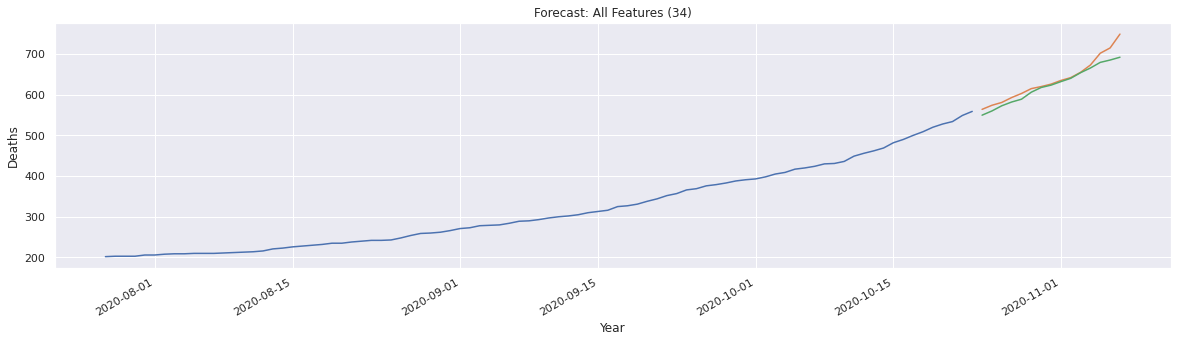

In [37]:
fig, ax = plt.subplots(1, figsize=(20, 5))

ax.set_title('Forecast: All Features (34)')
ax.set_ylabel(dep_var)
ax.set_xlabel('Year')
fig.autofmt_xdate()
ax.plot(pred_reg_train_df[dep_var])
ax.plot(pred_reg_test_df[[dep_var, 'Predictions']])


# Συνοψίζοντας:

**IBM Watson Studio**

Θετικά:
* Μπορείς να τρέξεις την εφαρμογή σου σε πραγματικά παράλληλους επεξεργαστές.
* Δεν ασχολείσαι με την εγκατάσταση του Pyspark.
* Υποστηρίζει όλες τις βασικές βιβλιοθήκες και τα εργαλεία που μπορεί να χρειαστείς.
* Είναι Δωρεάν μέχρι ένα μηνιαίο όριο επεξεργαστικής ισχύος.
* Επί πληρωμή, παρέχει ένα τεράστιο πλήθος επιλογών σε υλικό και προεγκατεστημένο λογισμικό.
* Τα δεδομένα που ανεβάζεις τα αποθηκεύει στον λογαριασμό σου στο cloud και τα φορτώνει κάθε φορά αυτόματα.
* Στην δωρεάν χρήση δεν σου ζητάει να προσθέσεις μέθοδο πληρωμής.

Αρνητικά:
* Πιο πολύπλοκη διαδικασία στησίματος της πλατφόρμας μέχρι να ξεκινήσεις να γράφεις κώδικα.
* Περιέχει βασικές βιβλιοθήκες και εργαλεία που οι εκδόσεις τους ενημερώνονται σποραδικά. Είναι πολύ πιθανό λοιπόν, να χρειαστείς να προσθέσεις χειροκίνητα ότι χρειάζεσαι.
* Ενδέχεται να προκύψουν ζητήματα διαφορετικών εκδόσεων μεταξύ βιβλιοθηκών στις χειροκίνητα προστειθέμενες.
* Οι δωρεάν επιλογές είναι περιορισμένες.
* Το μηνιαίο όριο επεξεργαστικής ισχύος μπορεί να ξοδευτεί γρήγορα αν γίνει χρήση ισχυρών μηχανών. Με μερικές εκτελέσεις και αλλαγές στον ήδη υπάρχον κώδικα ξόδεψα κιόλας 3.4/50 Capacity Unit Hours.

**Σκέψεις πάνω στο Watson Studio.**

Η πλατφόρμα είναι πολύ ακριβή για την δημιουργία εφαρμογής από το μηδέν. Ειδικά αν είμαστε δωρεάν χρήστες. Είναι όμως πολύ καλή επιλογή αν έχουμε ήδη έτοιμο κώδικα. Μπορεί να υποστηρίξει μοντέλα που εν' τέλει θα δουλεύουν πάνω σε πραγματικές καταστάσεις, που χρειάζεται να είναι διαρκώς εν λειτουργία και με δεδομένα που συλλέγονται διαρκώς ακόμα και πάνω από το δίκτυο. 

Η πλατφορμα αυτή χρησιμοποιείται από πολλές εταιρίες και είναι πολύ σημαντικό που έχουμε την δυνατότητα να την χρησιμοποιούμε και δωρεάν.